In [5]:
import os
import numpy as np
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 数据部分

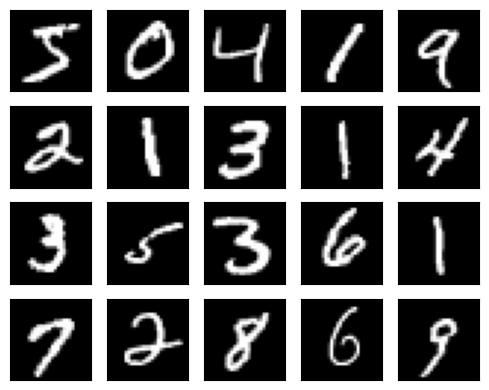

In [6]:
download_path = os.path.join(os.getcwd(), 'keras_mnist_datasets')
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data(path=download_path)

plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## 随机采样潜在样本latent sample
理论上采样的概率分布选择是随意的，均匀分布，正太分布都可以

这里选择标准正态分布，取样的尺寸要配合生成器，毕竟潜在样本是输入给生成器
- n_samples：其实代表数据批量大小，在训练的时候，必须配合数据的batch_size
- sample_size：尺寸，必须配合生成器的输入

In [7]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

make_latent_samples(1, 100) # generates one sample

array([[-1.88701016e-01, -6.07249857e-01, -1.41706121e-01,
         1.95093974e+00, -1.56563808e+00,  8.03755105e-01,
         3.66473467e-01,  4.49568495e-01,  2.54881738e+00,
         4.22968038e-01, -2.19905309e+00,  3.92082962e-01,
         5.17024538e-01, -8.13991039e-01,  5.90812465e-01,
         8.30486841e-01, -1.12088724e+00,  1.27609365e+00,
         1.20778213e-01, -1.32113607e-01, -1.64950374e+00,
         1.19279200e+00,  9.41587408e-01,  1.37214507e+00,
        -3.16757186e-01, -1.37209657e+00, -7.42834641e-01,
         2.18857349e+00,  3.67441601e-01, -1.08705731e+00,
        -9.22535979e-01, -1.03654285e-01, -9.66974085e-02,
        -5.96501639e-02, -3.01443415e-01, -5.10501140e-01,
         5.45325079e-01,  3.62623867e-01,  2.73277840e-01,
         6.54351335e-02,  2.23507069e-01, -1.01253234e+00,
         1.50692071e-01,  1.45486204e+00, -7.51189974e-01,
         9.73656355e-01,  1.85287506e+00,  5.91068906e-01,
        -3.31374313e-01,  5.01623044e-01,  6.53309607e-0

## 构建生成器Generator
注意：
- 第一个Dense层要求输入尺寸是100，这要求前面的潜在样本的sample_size必须100
- 细节：第二层的激活函数是tanh，据说效果最好

In [8]:
generator = Sequential([
    Dense(128, input_shape=(100,)),
    LeakyReLU(alpha=0.01),
    Dense(784),
    Activation('tanh')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               101136    
                                                                 
 activation (Activation)     (None, 784)               0         
                                                                 
Total params: 114064 (445.56 KB)
Trainable params: 114064 (445.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 构建判别器Discriminator

In [9]:
discriminator = Sequential([
    Dense(128, input_shape=(784,)),
    LeakyReLU(alpha=0.01),
    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 100609 (393.00 KB)
Trainable params: 100609 (393.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## GAN

In [10]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 784)               114064    
                                                                 
 discriminator (Sequential)  (None, 1)                 100609    
                                                                 
Total params: 214673 (838.57 KB)
Trainable params: 214673 (838.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
def make_simple_GAN(sample_size, 
                    g_hidden_size, 
                    d_hidden_size, 
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(784),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size, input_shape=(784,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    # adam优化器，二元交叉熵损失
    discriminator.compile(optimizer=Adam(learning_rate=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(learning_rate=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator 

## 数据预处理

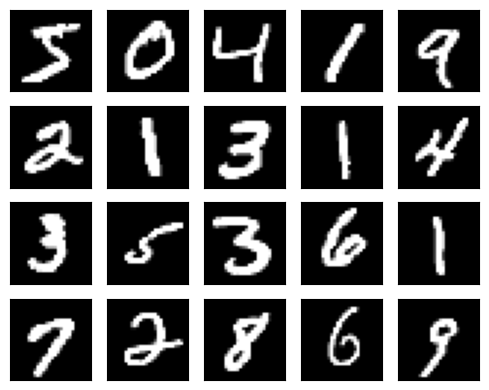

In [25]:
# 二维向量转化为向量，然后归一化
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

# 还原处理
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

#其实图片归一化以后仍然能显示
plt.figure(figsize=(5, 4))
for i in range(20):
    img = deprocess(X_train_real[i])
    # img = X_train_real[i].reshape(28,28)
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


## 控制模型是否可训练

In [26]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

make_trainable(discriminator, False)
discriminator.summary()

make_trainable(discriminator, True)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 100609 (393.00 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 100609 (393.00 KB)
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              P

## 训练循环
训练一下步骤使判别器和生成器变得越来越好
1. 准备一批真实图片
2. 使用潜在样本给生成器，生成一批假图像
3. 控制判别器可训练，训练鉴别器对真假图像进行分类
4. 控制判别器不可训练，训练生成器

### 超参数

In [27]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
# 细节：生成器的学习律更小
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

### 创建标签
鉴别器判别
1. 真实图像，标签为1
2. 假图像，标签为0

In [28]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])
    
# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

### 开始训练

In [29]:
# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # 一个批次四个步骤

        # 1.真实图像
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # 2.潜在样本
        latent_samples = make_latent_samples(batch_size, sample_size)
        # 生成器产生的假图片
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # 3.控制鉴别器可训练，并且用真实图片和假图片来训练
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # 4.控制鉴别器不可训练，训练gan，训练gan就是训练生成器
        make_trainable(discriminator, False)
        # 训练生成器，label是1，并且没有smooth处理
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    # 测试的真实图片
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    # 潜在样本，生成假图片
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    # 测试中的label不做smooth处理
    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))  

Epoch:   1/100 Discriminator Loss: 0.2811 Generator Loss: 3.8107
Epoch:   2/100 Discriminator Loss: 0.4824 Generator Loss: 1.2953
Epoch:   3/100 Discriminator Loss: 0.2450 Generator Loss: 3.5074
Epoch:   4/100 Discriminator Loss: 0.2277 Generator Loss: 1.9305
Epoch:   5/100 Discriminator Loss: 0.2488 Generator Loss: 1.8396
Epoch:   6/100 Discriminator Loss: 0.2143 Generator Loss: 2.2557
Epoch:   7/100 Discriminator Loss: 0.3161 Generator Loss: 3.4776
Epoch:   8/100 Discriminator Loss: 0.1651 Generator Loss: 2.6919
Epoch:   9/100 Discriminator Loss: 0.2734 Generator Loss: 3.8921
Epoch:  10/100 Discriminator Loss: 0.1394 Generator Loss: 4.2186
Epoch:  11/100 Discriminator Loss: 0.1631 Generator Loss: 2.4930
Epoch:  12/100 Discriminator Loss: 0.2388 Generator Loss: 2.0304
Epoch:  13/100 Discriminator Loss: 0.1655 Generator Loss: 3.3128
Epoch:  14/100 Discriminator Loss: 0.2536 Generator Loss: 2.4201
Epoch:  15/100 Discriminator Loss: 0.4149 Generator Loss: 2.4125
Epoch:  16/100 Discrimina

### 可视化损失

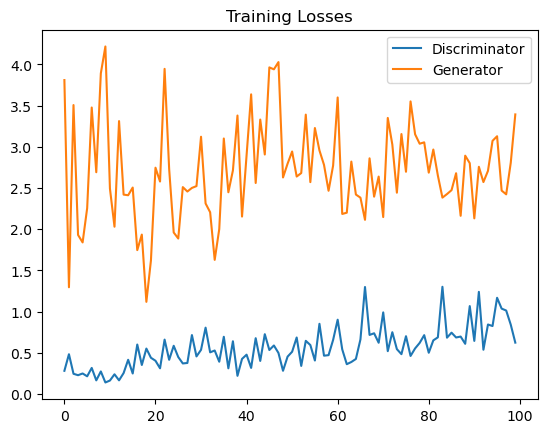

In [33]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

## 测试生成效果

1/1 [==============================] - 0s 34ms/step


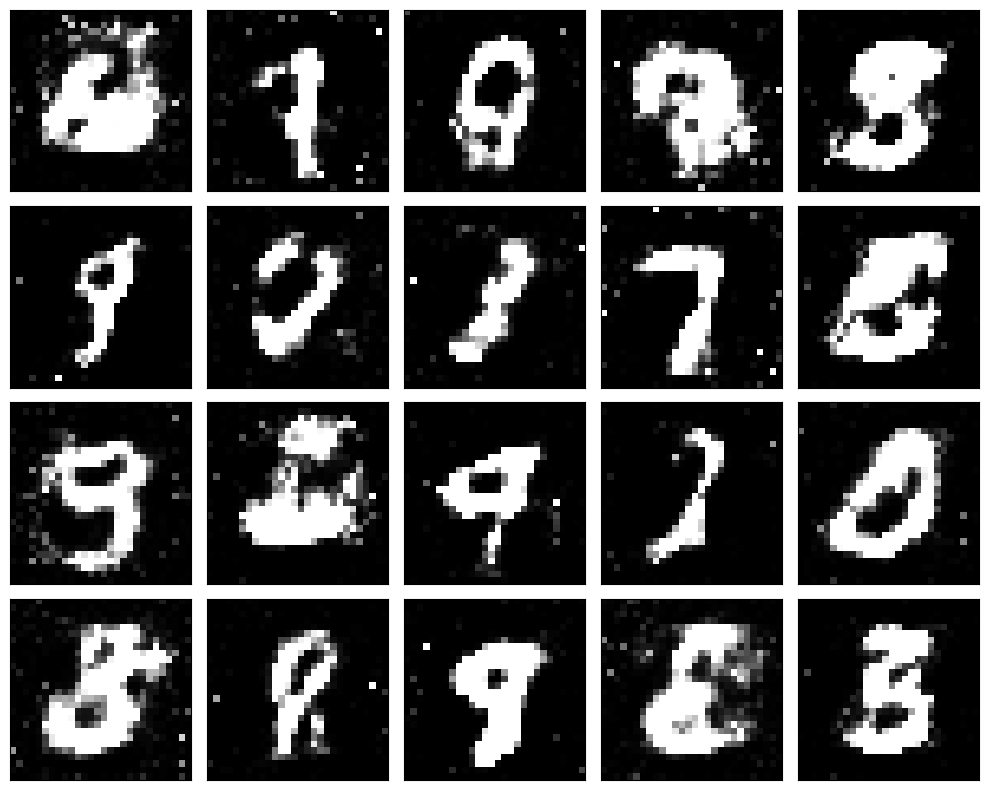

In [34]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()